In [15]:
import pandas as pd

In [16]:
df = pd.read_csv('data.csv')

In [17]:
df

,timestamp,Open,High,Low,Close,Volume,ema_short,ema_long,vwap,rsi,rsi_signal,macd,macd_signal,macd_hist,signal,pattern,signal_ema,signal_candlestick,positions
0,2024-09-08 05:45:00,54457.00,54458.00,54396.87,54403.66,17.63958,54403.660000,54403.660000,54403.660000,NaN,0.0,0.000000,0.0,0.000000,0.0,NaN,0.0,0.0,NaN
1,2024-09-08 05:50:00,54403.67,54411.82,54381.00,54381.00,22.53598,54394.596000,54401.916923,54390.949155,NaN,0.0,-1.807635,-1.0,-1.446108,0.0,NaN,-1.0,0.0,0.0
2,2024-09-08 05:55:00,54381.01,54381.01,54327.52,54344.01,44.45864,54374.361600,54397.462544,54366.291854,NaN,0.0,-6.154043,-1.0,-4.634013,0.0,NaN,-1.0,0.0,0.0
3,2024-09-08 06:00:00,54344.01,54390.00,54340.00,54382.00,16.05864,54377.416960,54396.273118,54368.797011,NaN,0.0,-6.458676,-1.0,-3.950916,0.0,NaN,0.0,0.0,0.0
4,2024-09-08 06:05:00,54382.01,54408.00,54372.00,54408.00,18.39802,54389.650176,54397.175186,54374.853374,NaN,0.0,-4.549671,-1.0,-1.633529,0.0,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,2024-09-15 05:20:00,60160.01,60167.99,60160.00,60167.98,34.06198,60158.389919,60157.060256,57337.005390,44.604287,0.0,-6.047972,1.0,2.821059,0.0,NaN,1.0,0.0,0.0
2012,2024-09-15 05:25:00,60167.98,60208.85,60167.98,60208.85,20.21315,60178.573951,60161.044082,57337.332401,50.893054,0.0,-1.003159,1.0,6.292698,0.0,NaN,1.0,0.0,0.0
2013,2024-09-15 05:30:00,60208.84,60214.89,60186.00,60186.01,16.42712,60181.548371,60162.964538,57337.595994,67.455794,0.0,1.138767,1.0,6.747700,0.0,NaN,1.0,0.0,0.0
2014,2024-09-15 05:35:00,60186.00,60188.00,60186.00,60187.99,5.73487,60184.125022,60164.889573,57337.688069,64.049720,0.0,2.961886,1.0,6.856655,0.0,NaN,1.0,0.0,0.0


In [19]:
df['signal_ema'] == df['macd_signal'] == df['rsi_signal']

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [7]:
import pandas as pd
import numpy as np
from binance.client import Client
import matplotlib.pyplot as plt
import time
from datetime import datetime
from dotenv import load_dotenv
import os
import requests
from matplotlib.animation import FuncAnimation
import threading



load_dotenv()

# Carregar as variáveis de ambiente
chat_id = os.getenv('CHAT_ID')
token = os.getenv('TOKEN')
api_key = os.getenv('API_KEY')
api_secret = os.getenv('API_SECRET')

# Inicializar o cliente da Binance
client = Client(api_key, api_secret)

In [8]:
def send_telegram_message(message):
    """Envia uma mensagem para o Telegram."""
    try:
        print(f"Enviando mensagem para o Telegram: {message}")
        url_base = f'https://api.telegram.org/bot{token}/sendMessage'
        params = {'chat_id': chat_id, 'text': message}
        response = requests.get(url_base, params=params)
        response.raise_for_status()
        print("Mensagem enviada com sucesso.")
        return response.json()['result']['message_id']
    except requests.RequestException as e:
        print(f"Erro ao enviar mensagem para o Telegram: {e}")
        return None

In [9]:
def calculate_indicators_with_patterns(data, ema_short_period, ema_long_period, rsi_period=14):
    """Calcula indicadores e detecta padrões de candle sem usar TA-Lib."""
    print(f"Calculando indicadores com EMA Curta: {ema_short_period}, EMA Longa: {ema_long_period}, RSI Período: {rsi_period}")
    
    # EMAs e VWAP
    data['ema_short'] = data['Close'].ewm(span=ema_short_period, adjust=False).mean()
    data['ema_long'] = data['Close'].ewm(span=ema_long_period, adjust=False).mean()
    data['vwap'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()
    
    # Cálculo do RSI
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
    rs = gain / loss
    data['rsi'] = 100 - (100 / (1 + rs))
    data['rsi_signal'] = np.where(data['rsi'] > 70, -1.0, np.where(data['rsi'] < 30, 1.0, 0.0))
    
    # MACD
    exp1 = data['Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Close'].ewm(span=26, adjust=False).mean()
    data['macd'] = exp1 - exp2
    data['macd_signal'] = data['macd'].ewm(span=9, adjust=False).mean()
    data['macd_hist'] = data['macd'] - data['macd_signal']
    
    # Bandas de Bollinger
    data['middle_band'] = data['Close'].rolling(window=20).mean()
    data['std_dev'] = data['Close'].rolling(window=20).std()
    data['upper_band'] = data['middle_band'] + (data['std_dev'] * 2)
    data['lower_band'] = data['middle_band'] - (data['std_dev'] * 2)
    data['band_signal'] = np.where(data['Close'] > data['upper_band'], -1.0, np.where(data['Close'] < data['lower_band'], 1.0, 0.0))
    
    # Inicializar os sinais baseados nos indicadores (EMA, RSI, MACD)
    data['signal'] = 0

    # Sinais baseados no RSI
    
    # Sinais baseados em EMAs e VWAP
    # data['signal'] = np.where(
    #     (data['ema_short'] > data['ema_long']) & (data['Close'] > data['vwap']), 1.0,
    #     np.where((data['ema_short'] < data['ema_long']) & (data['Close'] < data['vwap']), -1.0, 0.0)
    # )
    
    # # Combinar sinais: se houver sinal de RSI, usá-lo; senão, usar o sinal baseado em EMAs
    # data['signal'] = np.where(data['rsi_signal'] != 0, data['rsi_signal'], data['signal'])

    # Agora, calcular os padrões de candlestick separadamente
    def candlestick_signals(row):

        # Caso contrário, aplicar a lógica de padrões de candle
        if row['pattern'] == 'Bullish Engulfing' or row['pattern'] == 'Hammer' or row['pattern'] == 'Inverted Hammer':
            return 1  # Sinal de compra baseado em candlestick
        elif row['pattern'] == 'Bearish Engulfing' or row['pattern'] == 'Shooting Star':
            return -1  # Sinal de venda baseado em candlestick
        
        return 0  # Sem sinal

     # Agora, criar a coluna 'pattern' para os padrões de candlestick
    data['pattern'] = data.apply(lambda row: detect_candlestick_patterns(row, data), axis=1)

    # Aplicar sinais baseados nos padrões de candlestick, caso ainda não haja sinal técnico
    data['signal'] = data.apply(lambda row: candlestick_signals(row) if row['signal'] == 0 else row['signal'], axis=1)

    # Agora, criar a coluna 'positions' com base nos sinais
    data['positions'] = data['signal'].diff()  # Diferença entre sinais para detectar mudanças
    
    return data

In [10]:
def detect_candlestick_patterns(row, data):
    """Detecta padrões de candle específicos."""
    open_price = row['Open']
    high_price = row['High']
    low_price = row['Low']
    close_price = row['Close']
    
    # Definir o tamanho do candle e das sombras
    body = abs(close_price - open_price)
    upper_shadow = high_price - max(close_price, open_price)
    lower_shadow = min(close_price, open_price) - low_price
    
    # Critérios para o padrão Engolfo de Alta
    if is_bullish_engulfing(row, data):
        return 'Bullish Engulfing'
    # Critérios para o padrão Engolfo de Baixa
    elif is_bearish_engulfing(row, data):
        return 'Bearish Engulfing'
    # Critérios para o padrão Martelo
    elif is_hammer(row):
        return 'Hammer'
    # Critérios para o padrão Martelo Invertido
    elif is_inverted_hammer(row):
        return 'Inverted Hammer'
    # Critérios para o padrão Estrela Cadente
    elif is_shooting_star(row):
        return 'Shooting Star'
    else:
        return None

def is_bullish_engulfing(row, data):
    """Detecta o padrão Engolfo de Alta."""
    try:
        prev_row = data.loc[data.index.get_loc(row.name) - 1]
        return (
            prev_row['Close'] < prev_row['Open'] and  # Candle anterior de baixa
            row['Close'] > row['Open'] and  # Candle atual de alta
            row['Close'] > prev_row['Open'] and  # Fechamento do atual maior que a abertura do anterior
            row['Open'] < prev_row['Close']  # Abertura do atual menor que o fechamento do anterior
        )
    except (KeyError, IndexError):
        return False

def is_bearish_engulfing(row, data):
    """Detecta o padrão Engolfo de Baixa."""
    try:
        prev_row = data.loc[data.index.get_loc(row.name) - 1]
        return (
            prev_row['Close'] > prev_row['Open'] and  # Candle anterior de alta
            row['Close'] < row['Open'] and  # Candle atual de baixa
            row['Open'] > prev_row['Close'] and  # Abertura do atual maior que o fechamento do anterior
            row['Close'] < prev_row['Open']  # Fechamento do atual menor que a abertura do anterior
        )
    except (KeyError, IndexError):
        return False

def is_hammer(row):
    """Detecta o padrão Martelo."""
    body = abs(row['Close'] - row['Open'])
    upper_shadow = row['High'] - max(row['Close'], row['Open'])
    lower_shadow = min(row['Close'], row['Open']) - row['Low']
    
    return (
        body < upper_shadow * 0.5 and
        lower_shadow > body * 2 and
        upper_shadow < body
    )

def is_inverted_hammer(row):
    """Detecta o padrão Martelo Invertido."""
    body = abs(row['Close'] - row['Open'])
    upper_shadow = row['High'] - max(row['Close'], row['Open'])
    lower_shadow = min(row['Close'], row['Open']) - row['Low']
    
    return (
        body < lower_shadow * 0.5 and
        upper_shadow > body * 2 and
        lower_shadow < body
    )

def is_shooting_star(row):
    """Detecta o padrão Estrela Cadente."""
    return is_inverted_hammer(row) and row['Close'] < row['Open']

# Funções para detectar padrões de gráfico complexos
# Placeholder para futuras implementações
def detect_head_and_shoulders(data):
    """Detectar padrão de cabeça e ombros."""
    # Implementação detalhada seria necessária aqui
    return pd.Series([0]*len(data), index=data.index)

def detect_symmetrical_triangle(data):
    """Detectar padrão de triângulo simétrico."""
    # Implementação detalhada seria necessária aqui
    return pd.Series([0]*len(data), index=data.index)

def detect_flags(data):
    """Detectar bandeiras de alta e baixa."""
    # Implementação detalhada seria necessária aqui
    return pd.Series([0]*len(data), index=data.index), pd.Series([0]*len(data), index=data.index)

def detect_wedges(data):
    """Detectar cunhas de alta e baixa."""
    # Implementação detalhada seria necessária aqui
    return pd.Series([0]*len(data), index=data.index), pd.Series([0]*len(data), index=data.index)

In [11]:
def backtest(data, initial_capital):
    """Executa o backtest com base nos sinais de compra/venda."""
    positions = data['signal'].copy()
    cash_flow = -positions.diff().multiply(data['Close'])
    portfolio = pd.DataFrame({
        'positions': positions.multiply(data['Close']),
        'cash': initial_capital + cash_flow.cumsum()
    })
    portfolio['total'] = portfolio['positions'] + portfolio['cash']
    portfolio['returns'] = portfolio['total'].pct_change()
    return portfolio

def get_historical_data(symbol, interval, period):
    """Carrega dados históricos do Binance."""
    print(f"Carregando dados históricos para {symbol} com intervalo {interval} e período {period}.")
    klines = client.get_historical_klines(symbol, interval, period)
    data = pd.DataFrame(klines, columns=[
        'timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 
        'Close_time', 'Quote_asset_volume', 'Number_of_trades', 
        'Taker_buy_base_asset_volume', 'Taker_buy_quote_asset_volume', 'Ignore'
    ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    data.set_index('timestamp', inplace=True)
    print(f"Dados carregados: {data.shape[0]} linhas")
    return data[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)

Carregando dados históricos para BTCUSDT com intervalo 5m e período 7 days ago UTC.
Dados carregados: 2016 linhas

Melhor total: 0 com EMA Curta: 3, EMA Longa: 23, e RSI Período: 14
Calculando indicadores com EMA Curta: 3, EMA Longa: 23, RSI Período: 14
Dados carregados: 2016 linhas


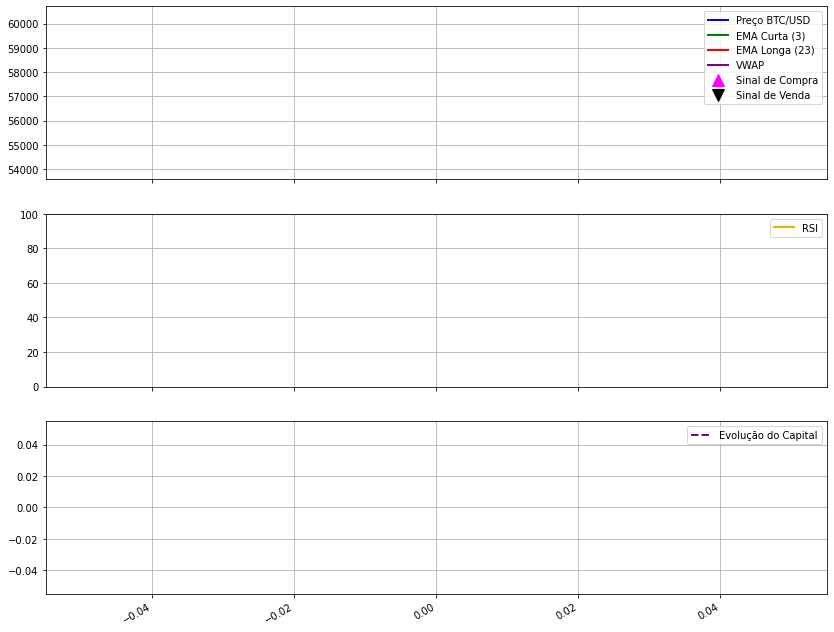

In [12]:
# Parâmetros iniciais
initial_capital = 10000.0
# Otimização dos parâmetros EMA
best_total = 0
best_ema_short_period = 3
best_ema_long_period = 23
best_rsi_period = 14

# Carregar os dados históricos do BTC/USD com intervalo de 1 minuto
data = get_historical_data('BTCUSDT', Client.KLINE_INTERVAL_5MINUTE, '7 days ago UTC')

# Testar diferentes combinações de períodos das EMAs
# for ema_short_period in range(3, 15):
#     for ema_long_period in range(15, 50):
#         data_with_indicators = calculate_indicators_with_patterns(data.copy(), ema_short_period, ema_long_period, best_rsi_period)
#         portfolio = backtest(data_with_indicators, initial_capital)
#         final_total = portfolio['total'].iloc[-1]
        
#         if final_total > best_total:
#             best_total = final_total
#             best_ema_short_period = ema_short_period
#             best_ema_long_period = ema_long_period
#             print(f"Novo melhor total: {best_total} com EMA Curta: {best_ema_short_period}, EMA Longa: {best_ema_long_period} e RSI Período: {best_rsi_period}")

best_ema_short_period = 3
best_ema_long_period = 23

print(f"\nMelhor total: {best_total} com EMA Curta: {best_ema_short_period}, EMA Longa: {best_ema_long_period}, e RSI Período: {best_rsi_period}")

# Calcular indicadores com os melhores parâmetros, incluindo o RSI
data = calculate_indicators_with_patterns(data, best_ema_short_period, best_ema_long_period, best_rsi_period)

if data.empty:
    print("Erro: Nenhum dado foi carregado.")
else:
    print(f"Dados carregados: {data.shape[0]} linhas")

# Executar backtest com os melhores parâmetros
portfolio = backtest(data, initial_capital)

# Inicializar a visualização
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))

# Plotar as linhas iniciais
line_price, = ax1.plot([], [], label='Preço BTC/USD', color='blue', lw=2)
line_ema_short, = ax1.plot([], [], label=f'EMA Curta ({best_ema_short_period})', color='green', lw=2)
line_ema_long, = ax1.plot([], [], label=f'EMA Longa ({best_ema_long_period})', color='red', lw=2)
line_vwap, = ax1.plot([], [], label='VWAP', color='purple', lw=2)
line_buy_signals, = ax1.plot([], [], '^', markersize=12, color='magenta', label='Sinal de Compra')
line_sell_signals, = ax1.plot([], [], 'v', markersize=12, color='black', label='Sinal de Venda')

line_rsi, = ax2.plot([], [], label='RSI', color='orange', lw=2)

# Adicionar estilo de linha para capital mais suave
line_capital, = ax3.plot([], [], label='Evolução do Capital', color='purple', lw=2, linestyle='--')

# Ajustar limites dos eixos manualmente
ax1.set_ylim([min(data['Close']) - 100, max(data['Close']) + 100])  # Ajustar escala do preço
ax2.set_ylim([0, 100])  # Escala típica do RSI (0-100)

# Adicionar legenda e grades
ax1.legend()
ax1.grid()

ax2.legend()
ax2.grid()

ax3.legend()
ax3.grid()

fig.autofmt_xdate()

In [13]:
def update_graph(frame):
    """Atualiza o gráfico com novos dados."""
    global data, portfolio, last_buy_signal_time, last_sell_signal_time

    try:
        print("Atualizando o gráfico...")
        
        # Recarregar os dados mais recentes da Binance
        data = get_historical_data('BTCUSDT', Client.KLINE_INTERVAL_5MINUTE, '7 days ago UTC')
        data = calculate_indicators_with_patterns(data, best_ema_short_period, best_ema_long_period, best_rsi_period)
        portfolio = backtest(data, initial_capital)
        
        # Verificar os dados carregados
        if data.empty:
            print("Erro: Nenhum dado foi carregado.")
            return
        else:
            print(f"Dados carregados: {data.shape[0]} linhas")

        data = data.tail(100)  # Apenas os últimos 100 pontos para melhor visualização
        portfolio = portfolio.tail(100)  # Apenas os últimos 100 pontos para melhor visualização
        
        # Aplicar média móvel no capital para suavização
        portfolio['total_smooth'] = portfolio['total'].rolling(window=10).mean()  # Média móvel de 10 períodos
        
        # Atualizar gráficos com dados completos
        line_price.set_data(data.index, data['Close'])
        line_ema_short.set_data(data.index, data['ema_short'])
        line_ema_long.set_data(data.index, data['ema_long'])
        line_vwap.set_data(data.index, data['vwap'])

        buy_signals = data.loc[data['positions'] == 1.0]
        sell_signals = data.loc[data['positions'] == -1.0]

        line_buy_signals.set_data(buy_signals.index, buy_signals['Close'])
        line_sell_signals.set_data(sell_signals.index, sell_signals['Close'])

        line_rsi.set_data(data.index, data['rsi'])

        # Atualizar o gráfico de capital com a média móvel
        line_capital.set_data(portfolio.index, portfolio['total_smooth'])

        # Ajustar limites dos eixos
        ax1.relim()
        ax1.autoscale_view()
        ax2.relim()
        ax2.autoscale_view()
        ax3.relim()
        ax3.autoscale_view()

        # Redesenhar a tela
        fig.canvas.draw()
        plt.pause(0.1)  # Pausar brevemente para garantir que o gráfico seja atualizado corretamente

    except Exception as e:
        # print traceback
        print(f"Erro ao atualizar o gráfico: {e}")

# Configurar animação
ani = FuncAnimation(fig, update_graph, interval=60000, cache_frame_data=False)

plt.show()


In [14]:
plt.show()